# Project description

Project for "WikiShop"

The online store "WikiShop" is launching a new service. Now users can edit and supplement product descriptions, just like in wiki communities. This means that customers suggest their edits and comment on other changes. The store needs a tool that will detect toxic comments and send them for moderation.

Train a model to classify comments as positive or negative. You have a dataset with labels for the toxicity of edits.

Build a model with an F1 score of at least 0.75.

# Table of contents

---

1. [Data](#data)
    * [Conclusion](#data-conclusion)
2. [Data preprocessing](#data-preprocessing)
    * [Text processing](#data-text-processing)
3. [Model preparation](#model-preparation)
    * [Datasets](#model-datasets-preparation)
    * [Hyperparameter tuning](#model-hyperparameter-tuning)
    * [Conclusion](#model-conclusion)
4. [Model training and testing](#model-training-and-testing)
5. [BERT model](#bert-model)
    * [Data preprocessing](#bert-data-preprocessing)
    * [Datasets](#bert-model-datasets-preparation)
    * [Model training and testing](#bert-model-model-training-and-testing)
6. [Conclusion](#conclusion)
---

## Data <a class="anchor" id="data"></a>

In [1]:
%%capture
!pip install transformers

In [2]:
import os
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import seaborn as sns
import torch
import transformers

from lightgbm import LGBMClassifier
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, train_test_split
    )
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from textblob import TextBlob, Word
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from tqdm import notebook
from transformers import (
    BertTokenizer, BertForSequenceClassification, AdamW
    )

In [3]:
# Searching for file
file_names = ['toxic_comments.csv']
url = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

file_path = None

for root, dirs, files in os.walk('.'):
    for file_name in file_names:
        if file_name in files:
            file_path = os.path.join(root, file_name)
            break
    else:
        continue
    break

if file_path is not None:
    df = pd.read_csv(file_path)
else:
    df = pd.read_csv(url)

# Ignoring all warnings and displaying all columns in the DF
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Basic information
print(f"Shape of dataframe: {df.shape}")
print(f"-" * 26)
print(f"Missing values in `toxic`: {df['toxic'].isnull().sum().sum()}")
print(f"-" * 26)
print(f"Unique values in `toxic`: {df['toxic'].nunique()}")
print(f"-" * 26)
print(f"Dataframe info: \n")
print(df.info())
print(f"-" * 26)
display(df[df['toxic']==1].sample(2))
display(df[df['toxic']==0].sample(2))

toxic_count_part = round(
    (df['toxic']==1).sum() / (
        (df['toxic']==0).sum() + (df['toxic']==1).sum()
    ) * 100, 2
)
print(f"Percentage of toxic comments: {toxic_count_part}%")

Shape of dataframe: (159292, 3)
--------------------------
Missing values in `toxic`: 0
--------------------------
Unique values in `toxic`: 2
--------------------------
Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None
--------------------------


,Unnamed: 0,text,toxic
35951,35993,"Page should just be deleted. \n\nNo, seriously...",1
115670,115769,my apologies \n\nsuck my junk bitch!!!,1


,Unnamed: 0,text,toxic
142553,142706,"oh, please81.178.153.156",0
79957,80033,the long-term effects of Fluoxetine,0


Percentage of toxic comments: 10.16%


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Conclusion <a class="anchor" id="data-conclusion"></a>

The initial data inspection showed:

- The data is represented in large quantities.
- The comments are either negative or not, no other value has been identified
-10.17% of the comments are toxic.
- A class imbalance has been identified, which needs to be addressed.

## Data preprocessing <a class="anchor" id="data-preprocessing"></a>

We will balance the data, it should be adjusted to the smaller class, that is, the toxic comments.

In [5]:
toxic_count = (df['toxic']==1).sum()

print(f"Number of toxic comments: {toxic_count} \n")

negative = df[df['toxic'] == 1]
positive = df[df['toxic'] == 0].sample(toxic_count)
df = pd.concat([negative, positive], axis=0).sample(frac=1)
df.reset_index(drop=True, inplace=True)

toxic_count_part = round(
    (df['toxic']==1).sum() / (
        (df['toxic']==0).sum() + (df['toxic']==1).sum()
    ) * 100, 2
)
print(
    f"Percentage of comments after balancing: {int(toxic_count_part)}%"
    )

df.sample(10)

Number of toxic comments: 16186 

Percentage of comments after balancing: 50%


,Unnamed: 0,text,toxic
19255,92644,Well its leading to a bit of a problem on the ...,0
30306,103856,"""\nYou dopy little fuck, """"wee curry monster""""...",1
8839,7245,It dont matter where u r...Kansas or anywhere ...,1
20057,89157,What the F son? \n\nHere I am trying to educat...,1
228,132553,"""\nIt is exactly about that. we don't know whe...",0
5840,45365,"""\n\n Mind Pollution and Sin Star votes \n\nI ...",0
19188,124270,What source is the higher Russian figure?,0
26714,49039,albert einstine was a foorball player for the ...,1
31238,75345,"""\n\nI think you are right, in that there may ...",0
350,24087,Hello \n\nHi there!\n\nPlz check my talkpage.\...,0


### Text processing <a class="anchor" id="data-text-processing"></a>

A text corpus creation:

In [6]:
corpus = df['text']

Text lemmatization and removing punctuation and double spaces.

In [7]:
demo_text = """ Rocks, papers and scissors.
                Tests     and testing. We are making something!!@#$%"""

def lemmatize_with_postag(text):
    sent = TextBlob(text.lower())
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [
        (w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

print(f"Original text: {demo_text}\n")
print(f"Lemmatized text: {lemmatize_with_postag(demo_text)}")

test_df = df.head(10)
test_df['text_lemmatized'] = test_df['text'].apply(lemmatize_with_postag)
test_df

Original text:  Rocks, papers and scissors.
                Tests     and testing. We are making something!!@#$%

Lemmatized text: rock paper and scissors test and test we be make something @ %


,Unnamed: 0,text,toxic,text_lemmatized
0,86147,"You dirty fuckers, why block me? Not busy eno...",1,you dirty fucker why block me not busy enough ...
1,12345,Idiot \n\nI just wanted to let you know that y...,1,idiot i just want to let you know that you and...
2,21514,Why do you like to deflower prepubescent girls...,1,why do you like to deflower prepubescent girl ...
3,125445,Is that your new strategy to claim there is no...,0,be that your new strategy to claim there be no...
4,12454,You're a motherfucking idiot\n\nYou're stupid ...,1,you 're a motherfucking idiot you 're stupid a...
5,41601,.\n\nI actually feel sorry for you,0,i actually feel sorry for you
6,118799,The Hand of God Game as it pertains to the 200...,0,the hand of god game a it pertain to the 2006 ...
7,30196,Good job. It's now much better referenced. I...,0,good job it 's now much well reference i move ...
8,1985,"""\nI really didn't expect it to """"fly."""" Thank...",0,i really do n't expect it to fly thanks for th...
9,138615,mother fucking cunt bitch,1,mother fuck cunt bitch


In [8]:
%%time

df['text_lemmatized'] = df['text'].apply(lemmatize_with_postag)
df = df[['text', 'text_lemmatized', 'toxic']]

df.head(10)

CPU times: user 2min 29s, sys: 2.21 s, total: 2min 31s
Wall time: 2min 43s


,text,text_lemmatized,toxic
0,"You dirty fuckers, why block me? Not busy eno...",you dirty fucker why block me not busy enough ...,1
1,Idiot \n\nI just wanted to let you know that y...,idiot i just want to let you know that you and...,1
2,Why do you like to deflower prepubescent girls...,why do you like to deflower prepubescent girl ...,1
3,Is that your new strategy to claim there is no...,be that your new strategy to claim there be no...,0
4,You're a motherfucking idiot\n\nYou're stupid ...,you 're a motherfucking idiot you 're stupid a...,1
5,.\n\nI actually feel sorry for you,i actually feel sorry for you,0
6,The Hand of God Game as it pertains to the 200...,the hand of god game a it pertain to the 2006 ...,0
7,Good job. It's now much better referenced. I...,good job it 's now much well reference i move ...,0
8,"""\nI really didn't expect it to """"fly."""" Thank...",i really do n't expect it to fly thanks for th...,0
9,mother fucking cunt bitch,mother fuck cunt bitch,1


## Model preparation <a class="anchor" id="model-preparation"></a>

### Datasets <a class="anchor" id="model-datasets-preparation"></a>

In [9]:
state = 8080

In [10]:
# Datasets split
X_train, X_test, y_train, y_test = train_test_split(
    df['text_lemmatized'], df['toxic'], test_size=0.2, random_state=state
    )

# Check the datasets size
x = df.shape[0]
a = X_train.shape[0]
b = y_test.shape[0]

def perc(pt, whl):
    return round(100 * pt / whl)

print(f"Original data: {x}")
print(f"Train dataset: {perc(a, x)}%, shape: {X_train.shape}")
print(f"Test dataset: {perc(b, x)}%, shape: {y_test.shape}")

Original data: 32372
Train dataset: 80%, shape: (25897,)
Test dataset: 20%, shape: (6475,)


### Hyperparameter tuning <a class="anchor" id="model-hyperparameter-tuning"></a>

The following models will be used:
1. DecisionTreeClassifier
2. RandomForestClassifier
3. LogisticRegression
4. LGBMClassifier

Best hyperparameters search via `Pipeline` using `RandomizedSearchCV` and `GridSearchCV`.

In [11]:
cv_value = 6
f1 = make_scorer(f1_score, average='binary')

**DecisionTreeClassifier**

Fitting 6 folds for each of 10 candidates, totalling 60 fits

Best parameters for DecisionTreeClassifier
{'dtc__min_samples_split': 270, 'dtc__min_samples_leaf': 3, 'dtc__max_depth': 156}

F1: 0.8394



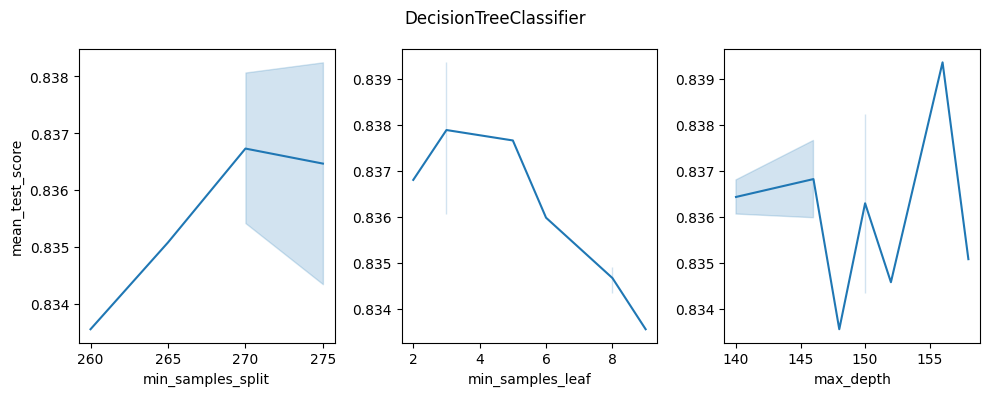

In [12]:
%%time
model_dtc = DecisionTreeClassifier(
    random_state=state, class_weight='balanced'
    )

params_dtc = {
    'dtc__min_samples_split': range(260, 285, 5),
    'dtc__min_samples_leaf': range(2, 10, 1),
    'dtc__max_depth': range(140, 162, 2)
}

# Define the model and parameters
pipeline_dtc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('dtc', model_dtc)
])

# Search the hyperparameters
grid_dtc = RandomizedSearchCV(
    pipeline_dtc,
    params_dtc,
    cv=cv_value,
    scoring='f1',
    n_jobs=-1,
    verbose=10
)
grid_dtc.fit(X_train, y_train)

# The best score, parameters and estimator
f1_dtc = grid_dtc.best_score_.round(4)
best_params_dtc = grid_dtc.best_params_
best_model_dtc = grid_dtc.best_estimator_

print(f"\nBest parameters for {type(model_dtc).__name__}")
print(f"{best_params_dtc}\n")
print(f"F1: {f1_dtc}\n")

# Plots with parameters performance
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4))
sns.lineplot(x='param_dtc__min_samples_split', y='mean_test_score',
             data=pd.DataFrame(grid_dtc.cv_results_), ax=axs[0])
sns.lineplot(x='param_dtc__min_samples_leaf', y='mean_test_score',
             data=pd.DataFrame(grid_dtc.cv_results_), ax=axs[1])
sns.lineplot(x='param_dtc__max_depth', y='mean_test_score',
             data=pd.DataFrame(grid_dtc.cv_results_), ax=axs[2])

fig.suptitle('DecisionTreeClassifier')
axs[0].set(xlabel='min_samples_split', ylabel='mean_test_score')
axs[1].set(xlabel='min_samples_leaf', ylabel='')
axs[2].set(xlabel='max_depth', ylabel='')

plt.tight_layout()
plt.show()

**RandomForestClassifier**

CPU times: user 11.3 s, sys: 621 ms, total: 11.9 s
Wall time: 4min 24s
Fitting 6 folds for each of 10 candidates, totalling 60 fits

Best parameters for RandomForestClassifier
{'rfc__min_samples_split': 28, 'rfc__min_samples_leaf': 3, 'rfc__max_leaf_nodes': 82, 'rfc__max_depth': 83}

F1: 0.8356



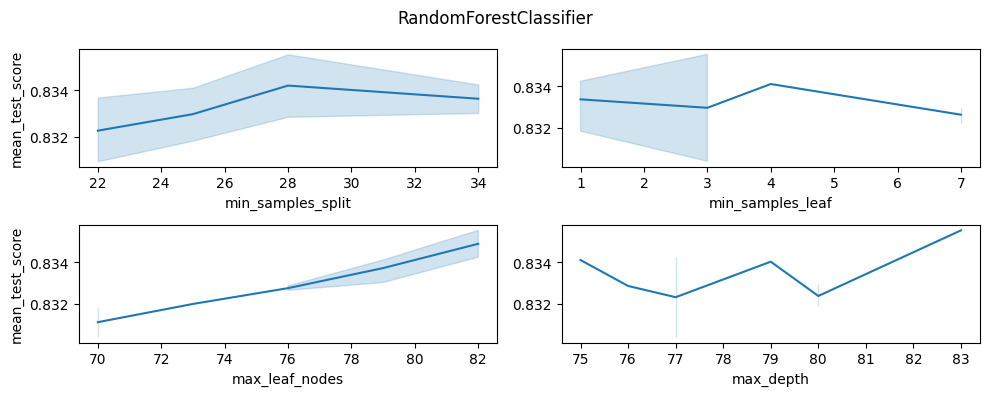

CPU times: user 5.5 s, sys: 446 ms, total: 5.95 s
Wall time: 2min 32s


In [13]:
%%time
model_rfc = RandomForestClassifier(
    random_state=state, class_weight='balanced'
    )

params_rfc = {
    'rfc__min_samples_split': range(22, 40, 3),
    'rfc__min_samples_leaf' : range(1, 8, 1),
    'rfc__max_leaf_nodes' : range(70, 85, 3),
    'rfc__max_depth' : range(75, 84, 1)
}

pipeline_rfc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('rfc', model_rfc)
])

grid_rfc = RandomizedSearchCV(
    pipeline_rfc,
    params_rfc,
    cv=cv_value,
    scoring='f1',
    n_jobs=-1,
    verbose=10
)
grid_rfc.fit(X_train, y_train)

f1_rfc = grid_rfc.best_score_.round(4)
best_params_rfc = grid_rfc.best_params_
best_model_rfc = grid_rfc.best_estimator_

print(f"\nBest parameters for {type(model_rfc).__name__}")
print(f"{best_params_rfc}\n")
print(f"F1: {f1_rfc}\n")

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 4))
sns.lineplot(x='param_rfc__min_samples_split', y='mean_test_score',
             data=pd.DataFrame(grid_rfc.cv_results_), ax=axs[0, 0]
             )
sns.lineplot(x='param_rfc__min_samples_leaf', y='mean_test_score',
             data=pd.DataFrame(grid_rfc.cv_results_), ax=axs[0, 1]
             )
sns.lineplot(x='param_rfc__max_leaf_nodes', y='mean_test_score',
             data=pd.DataFrame(grid_rfc.cv_results_), ax=axs[1, 0]
             )
sns.lineplot(x='param_rfc__max_depth', y='mean_test_score',
             data=pd.DataFrame(grid_rfc.cv_results_), ax=axs[1, 1]
             )

fig.suptitle('RandomForestClassifier')
axs[0, 0].set(xlabel='min_samples_split', ylabel='mean_test_score')
axs[0, 1].set(xlabel='min_samples_leaf', ylabel='')
axs[1, 0].set(xlabel='max_leaf_nodes', ylabel='mean_test_score')
axs[1, 1].set(xlabel='max_depth', ylabel='')

plt.tight_layout()
plt.show()

**LogisticRegression**

To prevent overfitting of LR and increase the regularization strength, smaller values of C are set.

Fitting 6 folds for each of 9 candidates, totalling 54 fits

Best parameters for LogisticRegression
{'lr__C': 0.5, 'lr__solver': 'lbfgs'}

F1: 0.8781



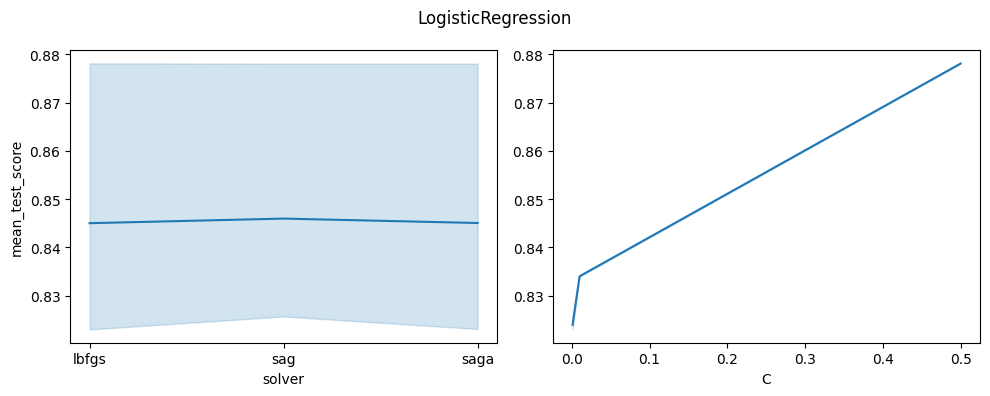

CPU times: user 3.33 s, sys: 1.03 s, total: 4.36 s
Wall time: 1min 8s


In [14]:
%%time
model_lr = LogisticRegression(random_state=state, class_weight='balanced')

params_lr = {
    'lr__C': [0.001, 0.01, 0.5],
    'lr__solver' : ['lbfgs', 'sag', 'saga']
}

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr', model_lr)
])

grid_lr = GridSearchCV(
    pipeline_lr,
    params_lr,
    cv=cv_value,
    scoring='f1',
    n_jobs=-1,
    verbose=10
)
grid_lr.fit(X_train, y_train)

f1_lr = grid_lr.best_score_.round(4)
best_params_lr = grid_lr.best_params_
best_model_lr = grid_lr.best_estimator_

print(f"\nBest parameters for {type(model_lr).__name__}")
print(f"{best_params_lr}\n")
print(f"F1: {f1_lr}\n")

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
sns.lineplot(x='param_lr__solver', y='mean_test_score',
             data=pd.DataFrame(grid_lr.cv_results_), ax=axs[0]
             )
sns.lineplot(x='param_lr__C', y='mean_test_score',
             data=pd.DataFrame(grid_lr.cv_results_), ax=axs[1]
             )

fig.suptitle('LogisticRegression')
axs[0].set(xlabel='solver', ylabel='mean_test_score')
axs[1].set(xlabel='C', ylabel='')

plt.tight_layout()
plt.show()

**LGBMClassifier**

Fitting 6 folds for each of 10 candidates, totalling 60 fits

Best parameters for LGBMClassifier
{'lgbmc__num_leaves': 5, 'lgbmc__max_depth': 25, 'lgbmc__learning_rate': 0.9}

F1: 0.8809



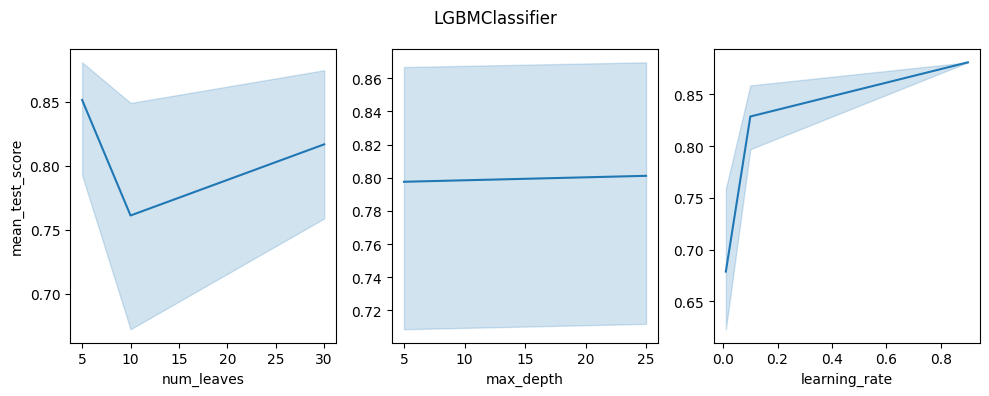

CPU times: user 6.78 s, sys: 502 ms, total: 7.28 s
Wall time: 4min 13s


In [15]:
%%time
model_lgbmc = LGBMClassifier(random_state=state)

params_lgbmc = {
    'lgbmc__num_leaves': [5, 10, 30],
    'lgbmc__max_depth': [5, 25],
    'lgbmc__learning_rate': [0.01, 0.1, 0.9]
}

pipeline_lgbmc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lgbmc', model_lgbmc)
])

grid_lgbmc = RandomizedSearchCV(
    pipeline_lgbmc,
    params_lgbmc,
    cv=cv_value,
    scoring='f1',
    n_jobs=-1,
    verbose=10
)
grid_lgbmc.fit(X_train, y_train)

f1_lgbmc = grid_lgbmc.best_score_.round(4)
best_params_lgbmc = grid_lgbmc.best_params_
best_model_lgbmc = grid_lgbmc.best_estimator_

print(f"\nBest parameters for {type(model_lgbmc).__name__}")
print(f"{best_params_lgbmc}\n")
print(f"F1: {f1_lgbmc}\n")

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4))
sns.lineplot(x='param_lgbmc__num_leaves', y='mean_test_score',
             data=pd.DataFrame(grid_lgbmc.cv_results_), ax=axs[0]
             )
sns.lineplot(x='param_lgbmc__max_depth', y='mean_test_score',
             data=pd.DataFrame(grid_lgbmc.cv_results_), ax=axs[1]
             )
sns.lineplot(x='param_lgbmc__learning_rate', y='mean_test_score',
             data=pd.DataFrame(grid_lgbmc.cv_results_), ax=axs[2]
             )

fig.suptitle('LGBMClassifier')
axs[0].set(xlabel='num_leaves', ylabel='mean_test_score')
axs[1].set(xlabel='max_depth', ylabel='')
axs[2].set(xlabel='learning_rate', ylabel='')

plt.tight_layout()
plt.show()

### Conclusion <a class="anchor" id="model-conclusion"></a>

For each model, we obtained the RMSE value during the parameter tuning process. Let's take a look at the best parameters found by `RandomizedSearchCV`:

In [16]:
params_vals = {'DTC'  : grid_dtc.best_params_,
               'RFC'  : grid_rfc.best_params_,
               'LR'   : grid_lr.best_params_,
               'LGBMC': grid_lgbmc.best_params_
}
params_df = pd.DataFrame(params_vals)
params_df.fillna('', inplace=True)
params_df

,DTC,RFC,LR,LGBMC
dtc__min_samples_split,270.0,,,
dtc__min_samples_leaf,3.0,,,
dtc__max_depth,156.0,,,
rfc__min_samples_split,,28.0,,
rfc__min_samples_leaf,,3.0,,
rfc__max_leaf_nodes,,82.0,,
rfc__max_depth,,83.0,,
lr__C,,,0.5,
lr__solver,,,lbfgs,
lgbmc__num_leaves,,,,5.0


## Model training and testing <a class="anchor" id="model-training-and-testing"></a>

We will train and test the models with the parameters selected by `RandomizedSearchCV`.

In [17]:
%%time

def get_f1_scores(models, X_train, X_test, y_train, y_test):
    results = pd.DataFrame(columns=['model_name', 'train_f1', 'test_f1'])
    for model in models:
        best_model = model.best_estimator_
        model_name = type(
            best_model.named_steps[model.best_estimator_.steps[-1][0]]
            ).__name__
        best_model.fit(X_train, y_train)
        predictions_train = best_model.predict(X_train)
        train_f1 = round(f1_score(predictions_train, y_train), 4)
        predictions_test = best_model.predict(X_test)
        test_f1 = round(f1_score(predictions_test, y_test), 4)
        results = results.append(
            {'model_name': model_name,
             'train_f1': train_f1,
             'test_f1': test_f1}, ignore_index=True
             )
    return results

models = [grid_dtc, grid_rfc, grid_lr, grid_lgbmc]
results = get_f1_scores(models, X_train, X_test, y_train, y_test)
results.sort_values(by='test_f1', ascending=False)

CPU times: user 22.8 s, sys: 706 ms, total: 23.5 s
Wall time: 22.9 s


,model_name,train_f1,test_f1
3,LGBMClassifier,0.9113,0.8835
2,LogisticRegression,0.9152,0.8816
0,DecisionTreeClassifier,0.8955,0.8382
1,RandomForestClassifier,0.8474,0.8276


## BERT model <a class="anchor" id="bert-model"></a>

In [18]:
# Check if CUDA is available
!nvidia-smi

Mon Apr 17 17:52:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data preprocessing <a class="anchor" id="bert-data-preprocessing"></a>

Preparing new datasets, tokenization and optimization of data for BERT.

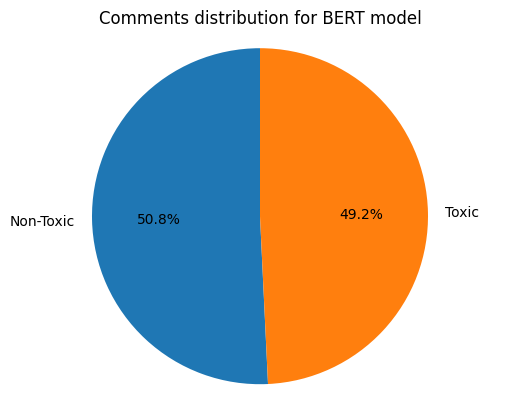

In [19]:
# Sample data
sampled_data = df.sample(5000).reset_index(drop=True)

# Count the number of instances with toxic=True and toxic=False
toxic_counts = sampled_data['toxic'].value_counts()

# Plot a pie chart
labels = ['Non-Toxic', 'Toxic']
sizes = [toxic_counts[0], toxic_counts[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('Comments distribution for BERT model')
plt.show()

In [20]:
# Set batch size and gradient accumulation steps
batch_size = 16
gradient_accumulation_steps = 4

# Load pre-trained BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained(
    'unitary/toxic-bert'
    )

# Tokenize text data using BERT tokenizer and encode into token IDs
# `df_bert` is assumed to be a pandas dataframe containing the text data
tokenized = sampled_data['text'].apply(
    lambda x: tokenizer.encode(
        x, max_length=512, truncation=True, add_special_tokens=True
        )
)

# Pad tokenized sequences to the same length using `pad_sequence`
# function from PyTorch. This function automatically pads sequences
# with 0s to match the maximum length of the sequences `batch_first=True`
# ensures that the output tensor has shape (batch_size, max_seq_len)
padded = pad_sequence(
    [torch.as_tensor(seq) for seq in tokenized], batch_first=True
    )

# Generate attention mask tensor to indicate which elements are
# padding tokens and which are actual tokens
# Attention mask tensor has same shape as padded tensor
attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor)

# Move tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
padded = padded.to(device)
attention_mask = attention_mask.to(device)

# Create dataloader
data = TensorDataset(padded, attention_mask)
loader = DataLoader(data, batch_size=batch_size)

# Load pre-trained BERT config and model from Hugging Face model hub
config = transformers.BertConfig.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained(
    'unitary/toxic-bert', config=config
    ).to(device)

# Define optimizer and learning rate
optimizer = AdamW(model.parameters(),
                  lr=0.00001,
                  weight_decay=0.01,
                  eps=1e-8,)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
%%time

# Create list for embeddings
embeddings = []

# Loop through batches
for i, batch in enumerate(notebook.tqdm(loader)):
    batch = [tensor.to(device) for tensor in batch]
    batch_embeddings = model(*batch)[0][:,0,:].detach().cpu().numpy()
    embeddings.append(batch_embeddings)
    # Perform gradient accumulation
    if (i + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()

features_bert = np.concatenate(embeddings)

  0%|          | 0/313 [00:00<?, ?it/s]

CPU times: user 2min 30s, sys: 434 ms, total: 2min 31s
Wall time: 2min 33s


### Datasets <a class="anchor" id="bert-model-datasets-preparation"></a>

In [22]:
# Datasets split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    features_bert, sampled_data['toxic'],
    test_size=0.2, random_state=state
    )

# Check the datasets size
x = sampled_data.shape[0]
a = X_train_bert.shape[0]
b = y_test_bert.shape[0]

def perc(pt, whl):
    return round(100 * pt / whl)

print(f"Original data: {x}")
print(f"Train dataset: {perc(a, x)}%, shape: {X_train_bert.shape}")
print(f"Test dataset: {perc(b, x)}%, shape: {y_test_bert.shape}")

Original data: 5000
Train dataset: 80%, shape: (4000, 768)
Test dataset: 20%, shape: (1000,)


### Model training and testing <a class="anchor" id="bert-model-model-training-and-testing"></a>

Since we have a new dataset it is neccesary to get best hyperparameters for each model.
The `cv` value will be doubled and `RandomizedSearchCV` will be used for tuning.

In [23]:
def run_model(pipeline, param_grid, model_name):
    # Search hyperparameters
    grid_search = RandomizedSearchCV(
        pipeline,
        param_grid,
        cv=(cv_value*2),
        scoring='f1',
        n_jobs=-1,
        verbose=10
    )
    grid_search.fit(X_train_bert, y_train_bert)
    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X_train_bert)
    y_pred_test = best_model.predict(X_test_bert)

    # Print the F1 metrics
    train_f1 = round(f1_score(y_train_bert, y_pred_train), 4)
    test_f1 = round(f1_score(y_test_bert, y_pred_test), 4)
    print(f"F1 score on train set: {train_f1:.4f}")
    print(f"F1 score on test set: {test_f1:.4f}")
    print(f"Best hyperparameters:\n{grid_search.best_params_}\n")

    return best_model, train_f1, test_f1

**DecisionTreeClassifier**

In [24]:
%%time

pipeline_dtc_bert = Pipeline(
    [('dtc', DecisionTreeClassifier(random_state=state))]
    )
params_dtc_bert = {
    'dtc__max_depth' : range(1, 30, 1),
    'dtc__min_samples_leaf': range(20, 80, 4),
    'dtc__min_samples_split': range(2, 25, 1)
}

(best_model_dtc_bert,
 train_f1_dtc_bert, test_f1_dtc_bert) = run_model(
    pipeline_dtc_bert, params_dtc_bert, 'dtc'
    )


Fitting 12 folds for each of 10 candidates, totalling 120 fits
F1 score on train set: 0.9854
F1 score on test set: 0.9760
Best hyperparameters:
{'dtc__min_samples_split': 9, 'dtc__min_samples_leaf': 28, 'dtc__max_depth': 8}

CPU times: user 3.42 s, sys: 115 ms, total: 3.53 s
Wall time: 2min 14s


**RandomForestClassifier**

In [25]:
%%time

pipeline_rfc_bert = Pipeline(
    [('rfc', RandomForestClassifier(random_state=state))]
    )
params_rfc_bert = {
    'rfc__min_samples_split': range(2, 60, 3),
    'rfc__min_samples_leaf' : range(1, 30, 2),
    'rfc__max_leaf_nodes' : range(10, 50, 5),
    'rfc__max_depth' : range(40, 80, 3)
}

(best_model_rfc_bert,
 train_f1_rfc_bert, test_f1_rfc_bert) = run_model(
    pipeline_rfc_bert, params_rfc_bert, 'rfc'
    )


Fitting 12 folds for each of 10 candidates, totalling 120 fits
F1 score on train set: 0.9926
F1 score on test set: 0.9817
Best hyperparameters:
{'rfc__min_samples_split': 23, 'rfc__min_samples_leaf': 1, 'rfc__max_leaf_nodes': 20, 'rfc__max_depth': 46}

CPU times: user 8.5 s, sys: 276 ms, total: 8.77 s
Wall time: 7min 26s


**LogisticRegression**

In [26]:
%%time

pipeline_lr_bert = Pipeline(
    [('lr', LogisticRegression(random_state=state))]
    )
params_lr_bert = {
    'lr__C': [0.001, 0.01, 0.5],
    'lr__solver' : ['lbfgs', 'sag', 'saga']
}

(best_model_lr_bert,
 train_f1_lr_bert, test_f1_lr_bert) = run_model(
    pipeline_lr_bert, params_lr_bert, 'lr'
    )

Fitting 12 folds for each of 9 candidates, totalling 108 fits
F1 score on train set: 0.9849
F1 score on test set: 0.9807
Best hyperparameters:
{'lr__solver': 'lbfgs', 'lr__C': 0.01}

CPU times: user 1.48 s, sys: 194 ms, total: 1.68 s
Wall time: 3min 22s


In [27]:
%%time

pipeline_lgbmc_bert = Pipeline(
    [('lgbmc', LGBMClassifier(random_state=state))]
    )
params_lgbmc_bert = {
    'lgbmc__num_leaves': [5, 10, 30],
    'lgbmc__max_depth': [5, 25],
    'lgbmc__learning_rate': [0.01, 0.1, 0.9]
}

(best_model_lgbmc_bert,
 train_f1_lgbmc_bert, test_f1_lgbmc_bert) = run_model(
    pipeline_lgbmc_bert, params_lgbmc_bert, 'lgbmc'
    )

Fitting 12 folds for each of 10 candidates, totalling 120 fits
F1 score on train set: 1.0000
F1 score on test set: 0.9807
Best hyperparameters:
{'lgbmc__num_leaves': 10, 'lgbmc__max_depth': 5, 'lgbmc__learning_rate': 0.1}

CPU times: user 6.67 s, sys: 283 ms, total: 6.95 s
Wall time: 5min 38s


Final results (Pipeline vs BERT):

In [28]:
bert_f1 = {'model' : ['DecisionTreeClassifier', 'RandomForestClassifier',
                      'LogisticRegression', 'LGBMClassifier'],
           'F1 (BERT)' : [test_f1_dtc_bert, test_f1_rfc_bert,
                          test_f1_lr_bert, test_f1_lgbmc_bert]}

results_bert = pd.DataFrame(data=bert_f1)

final_results = pd.concat([results, results_bert], axis=1)
final_results = final_results.drop(['model', 'train_f1'], axis=1)
final_results = final_results.rename(columns={'test_f1': 'F1 (Pipeline)'})
final_results

,model_name,F1 (Pipeline),F1 (BERT)
0,DecisionTreeClassifier,0.8382,0.9760
1,RandomForestClassifier,0.8276,0.9817
2,LogisticRegression,0.8816,0.9807
3,LGBMClassifier,0.8835,0.9807


## Conclusion <a class="anchor" id="conclusion"></a>

- At the initial examination of the data, a serious class imbalance was found - the percentage of toxic comments was 10.17%. To address the imbalance, the number of non-toxic comments was reduced to match the number of negative comments, resulting in a final sample size of 32450. Next, lemmatization and preparation of train/test sets were performed.
- Then, optimal parameters were selected with a focus on the `F1` metric.
- Four models were selected for training and trained on the train and test sets with the best parameters.
- Additionally, the `BERT` model was implemented. The datasets were prepared and needed data encoded, the trained models were tested on the obtained sample.
- Finally, the best models and `F1` values were identified in the comparative table. For more clarity they are printed out below:

In [29]:
final_model_pipe = final_results.sort_values(
    by='F1 (Pipeline)', ascending=False
    )
print(
    f"""Best model (Pipeline): 
    {final_model_pipe.iloc[0, 0]}, F1: {final_model_pipe.iloc[0, 1]}"""
    )
final_model_bert = final_results.sort_values(
    by='F1 (BERT)', ascending=False
    )
print(
    f"""Best model (BERT): 
    {final_model_bert.iloc[0, 0]}, F1: {final_model_bert.iloc[0, 2]}"""
)

Best model (Pipeline): 
    LGBMClassifier, F1: 0.8835
Best model (BERT): 
    RandomForestClassifier, F1: 0.9817
